<a href="https://colab.research.google.com/github/Haign12/Lab_ChuyenDeXyLyAnhVaVideoSo_21126076/blob/main/Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip -q install torchinfo scikit-learn


In [2]:
import os
import math
import random
import time
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST, FashionMNIST

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from torchinfo import summary

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("Device:", device)


PyTorch: 2.6.0+cu124
Torchvision: 0.21.0+cu124
Device: cuda


In [4]:
DATASET = "CIFAR10"
DATA_ROOT = "./data"

EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

USE_AUG = True

VAL_SPLIT = 0.1
NUM_WORKERS = 2



100%|██████████| 170M/170M [00:08<00:00, 20.7MB/s]


Dataset: CIFAR10
Train: 45000 | Val: 5000 | Test: 10000


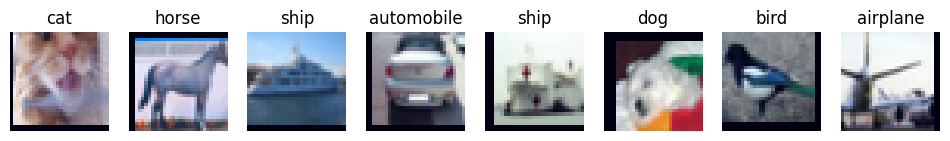

In [5]:

if DATASET.upper() == "CIFAR10":
    in_channels = 3
    num_classes = 10
    input_size = 32
    normalize = transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616)
    )
    train_tf = [
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip() if USE_AUG else transforms.Lambda(lambda x: x),
        transforms.RandomCrop(32, padding=4) if USE_AUG else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        normalize,
    ]
    test_tf = [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        normalize,
    ]

    train_dataset_full = CIFAR10(root=DATA_ROOT, train=True, download=True, transform=transforms.Compose(train_tf))
    test_dataset = CIFAR10(root=DATA_ROOT, train=False, download=True, transform=transforms.Compose(test_tf))
    class_names = train_dataset_full.classes

elif DATASET.upper() == "MNIST":
    in_channels = 1
    num_classes = 10
    input_size = 32
    normalize = transforms.Normalize((0.1307,), (0.3081,))
    train_tf = [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        normalize,
    ]
    test_tf = [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        normalize,
    ]
    train_dataset_full = MNIST(root=DATA_ROOT, train=True, download=True, transform=transforms.Compose(train_tf))
    test_dataset = MNIST(root=DATA_ROOT, train=False, download=True, transform=transforms.Compose(test_tf))
    class_names = [str(i) for i in range(10)]

elif DATASET.upper() == "FASHIONMNIST":
    in_channels = 1
    num_classes = 10
    input_size = 32
    normalize = transforms.Normalize((0.2860,), (0.3530,))
    train_tf = [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        normalize,
    ]
    test_tf = [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        normalize,
    ]
    train_dataset_full = FashionMNIST(root=DATA_ROOT, train=True, download=True, transform=transforms.Compose(train_tf))
    test_dataset = FashionMNIST(root=DATA_ROOT, train=False, download=True, transform=transforms.Compose(test_tf))
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
else:
    raise ValueError("DATASET phải là 'CIFAR10', 'MNIST', hoặc 'FashionMNIST'.")

# Tách train/val
n_total = len(train_dataset_full)
n_val = int(n_total * VAL_SPLIT)
n_train = n_total - n_val
train_dataset, val_dataset = random_split(train_dataset_full, [n_train, n_val])

print(f"Dataset: {DATASET}")
print(f"Train: {n_train} | Val: {n_val} | Test: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

def show_batch(dloader, n=8):
    xs, ys = next(iter(dloader))
    xs = xs[:n]
    ys = ys[:n]
    fig = plt.figure(figsize=(12, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        img = xs[i].permute(1, 2, 0).cpu().numpy()
        if in_channels == 1:
            img = img.squeeze(-1)
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow((img - img.min()) / (img.max() - img.min() + 1e-8))
        ax.set_title(class_names[ys[i]] if isinstance(class_names[0], str) else ys[i].item())
        plt.axis("off")
    plt.show()

show_batch(train_loader, n=8)


In [6]:

class SimpleCNN(nn.Module):
    '''
    3-block CNN, dùng AdaptiveAvgPool2d để độc lập kích thước input (ở đây ta đã chuẩn hoá về 32x32).
    '''
    def __init__(self, in_channels=3, num_classes=10, dropout=0.2):
        super().__init__()
        def conv_block(c_in, c_out):
            return nn.Sequential(
                nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(c_out),
                nn.ReLU(inplace=True),
                nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(c_out),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            )

        self.features = nn.Sequential(
            conv_block(in_channels, 32),
            conv_block(32, 64),
            conv_block(64, 128),
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(in_channels=in_channels, num_classes=num_classes, dropout=0.3).to(device)

try:
    summary(model, input_size=(128, in_channels, 32, 32))
except Exception as e:
    print("Summary warning:", e)
    print(model)


In [7]:

from tqdm.auto import tqdm

@dataclass
class History:
    train_loss: list
    train_acc: list
    val_loss: list
    val_acc: list

def accuracy_from_logits(logits, y):
    preds = logits.argmax(dim=1)
    acc = (preds == y).float().mean().item()
    return acc, preds

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, running_acc = 0.0, 0.0
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        acc, _ = accuracy_from_logits(logits, y)
        running_loss += loss.item() * x.size(0)
        running_acc += acc * x.size(0)
    n = len(loader.dataset)
    return running_loss / n, running_acc / n

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, running_acc = 0.0, 0.0
    all_preds, all_targets = [], []
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        acc, preds = accuracy_from_logits(logits, y)

        running_loss += loss.item() * x.size(0)
        running_acc += acc * x.size(0)
        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())
    n = len(loader.dataset)
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    return running_loss / n, running_acc / n, all_preds, all_targets

def plot_curves(hist: History):
    plt.figure(figsize=(6,4))
    plt.plot(hist.train_loss, label="train_loss")
    plt.plot(hist.val_loss, label="val_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(hist.train_acc, label="train_acc")
    plt.plot(hist.val_acc, label="val_acc")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.show()


  0%|          | 0/352 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7edeb0151e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7edeb0151e40>
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^    if w.is_alive():
     ^ ^ ^^^^^^^^^^^^

Epoch 01/10 | train_loss=1.3894 acc=49.22% | val_loss=1.1829 acc=56.56% | time=19.8s


  0%|          | 0/352 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7edeb0151e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7edeb0151e40>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        if w.is_alive():
self._shutdown_workers() 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():
       ^ ^ ^ ^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.11/

Epoch 02/10 | train_loss=1.0067 acc=64.21% | val_loss=0.9770 acc=64.30% | time=22.3s


  0%|          | 0/352 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7edeb0151e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7edeb0151e40>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    if w.is_alive():Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive(): 
         ^^^^^^^^ ^^^ ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python

Epoch 03/10 | train_loss=0.8469 acc=70.45% | val_loss=0.8967 acc=68.28% | time=21.3s


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 04/10 | train_loss=0.7389 acc=74.14% | val_loss=0.7620 acc=74.26% | time=20.8s


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 05/10 | train_loss=0.6610 acc=77.38% | val_loss=0.6617 acc=76.72% | time=20.0s


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 06/10 | train_loss=0.6029 acc=79.28% | val_loss=0.6795 acc=75.44% | time=20.0s


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 07/10 | train_loss=0.5506 acc=81.12% | val_loss=0.5538 acc=81.12% | time=19.8s


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 08/10 | train_loss=0.5074 acc=82.45% | val_loss=0.5033 acc=82.54% | time=20.0s


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 09/10 | train_loss=0.4799 acc=83.74% | val_loss=0.4917 acc=82.74% | time=19.1s


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 10/10 | train_loss=0.4592 acc=84.53% | val_loss=0.4730 acc=83.56% | time=20.4s
Best val acc: 83.56%


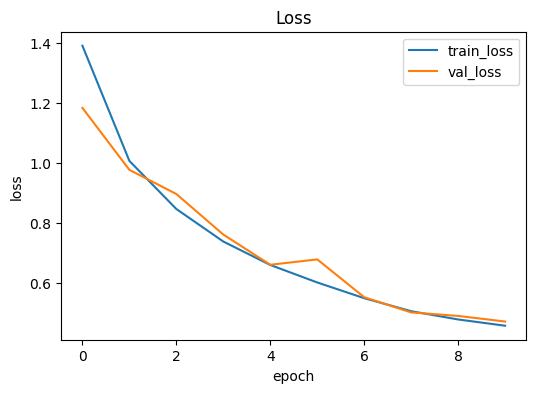

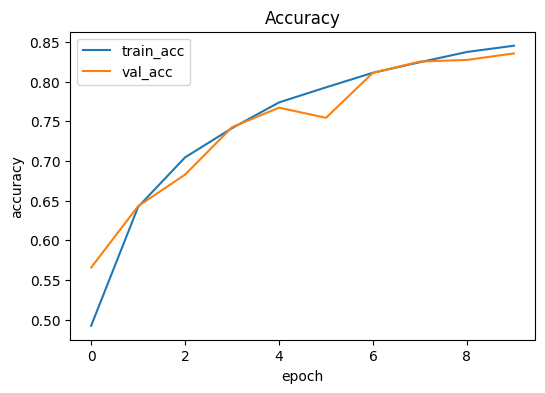

In [8]:

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

best_val_acc = 0.0
best_state = None

hist = History(train_loss=[], train_acc=[], val_loss=[], val_acc=[])

for epoch in range(1, EPOCHS+1):
    start = time.time()
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    scheduler.step()

    hist.train_loss.append(tr_loss)
    hist.train_acc.append(tr_acc)
    hist.val_loss.append(val_loss)
    hist.val_acc.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {
            "model": model.state_dict(),
            "epoch": epoch,
            "val_acc": val_acc,
            "config": {
                "dataset": DATASET,
                "in_channels": in_channels,
                "num_classes": num_classes,
                "epochs": EPOCHS,
                "batch_size": BATCH_SIZE,
                "lr": LEARNING_RATE,
                "weight_decay": WEIGHT_DECAY
            }
        }

    dt = time.time() - start
    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss={tr_loss:.4f} acc={tr_acc*100:.2f}% | "
          f"val_loss={val_loss:.4f} acc={val_acc*100:.2f}% | "
          f"time={dt:.1f}s")

print(f"Best val acc: {best_val_acc*100:.2f}%")
plot_curves(hist)


Test loss: 0.4768 | Test acc: 83.61%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.84      0.86      0.85      1000
  automobile       0.92      0.92      0.92      1000
        bird       0.75      0.77      0.76      1000
         cat       0.71      0.69      0.70      1000
        deer       0.81      0.83      0.82      1000
         dog       0.80      0.74      0.77      1000
        frog       0.85      0.89      0.87      1000
       horse       0.89      0.84      0.86      1000
        ship       0.91      0.92      0.91      1000
       truck       0.89      0.90      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



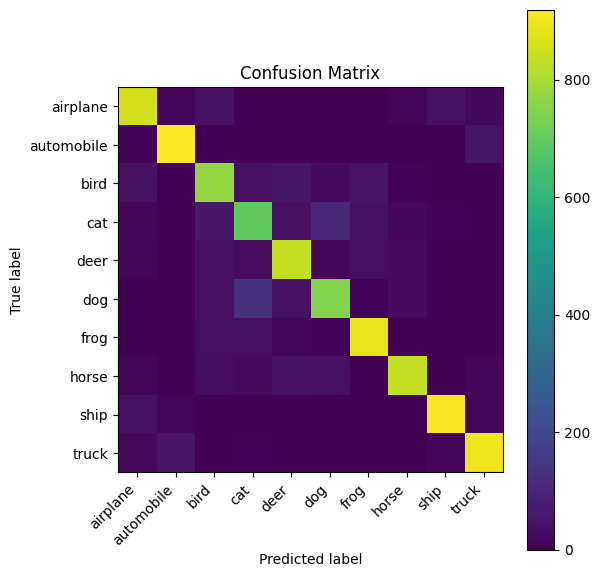

In [9]:
if best_state is not None:
    model.load_state_dict(best_state["model"])

test_loss, test_acc, test_preds, test_targets = evaluate(model, test_loader, criterion)
print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc*100:.2f}%")

print("\nClassification Report:")
print(classification_report(test_targets.numpy(), test_preds.numpy(), target_names=[str(c) for c in class_names]))

cm = confusion_matrix(test_targets.numpy(), test_preds.numpy())

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


Số mẫu dự đoán sai: 1639


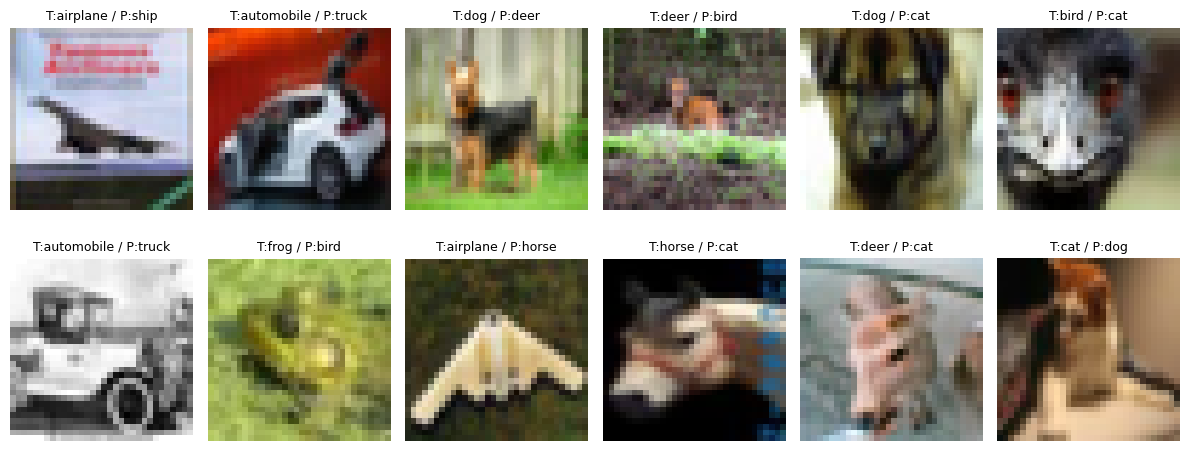

In [10]:
wrong_idx = (test_preds != test_targets).nonzero(as_tuple=False).squeeze(-1).tolist()
print(f"Số mẫu dự đoán sai: {len(wrong_idx)}")
samples_to_show = wrong_idx[:12]

if len(samples_to_show) > 0:
    xs = []
    ys = []
    ps = []
    if DATASET.upper() == "CIFAR10":
        raw_tf = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])
        raw_test = CIFAR10(root=DATA_ROOT, train=False, download=False, transform=raw_tf)
    elif DATASET.upper() == "MNIST":
        raw_tf = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])
        raw_test = MNIST(root=DATA_ROOT, train=False, download=False, transform=raw_tf)
    else:
        raw_tf = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])
        raw_test = FashionMNIST(root=DATA_ROOT, train=False, download=False, transform=raw_tf)

    for idx in samples_to_show:
        x, y = raw_test[idx]
        xs.append(x)
        ys.append(y)
        ps.append(test_preds[idx].item())

    n = len(xs)
    cols = 6
    rows = math.ceil(n / cols)
    plt.figure(figsize=(12, 2.5*rows))
    for i in range(n):
        ax = plt.subplot(rows, cols, i+1)
        img = xs[i].permute(1, 2, 0).cpu().numpy()
        if len(img.shape) == 3 and img.shape[2] == 1:
            img = img.squeeze(-1)
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow((img - img.min()) / (img.max() - img.min() + 1e-8))
        t = class_names[ys[i]] if isinstance(class_names[0], str) else ys[i]
        p = class_names[ps[i]] if isinstance(class_names[0], str) else ps[i]
        ax.set_title(f"T:{t} / P:{p}", fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [11]:

import json
os.makedirs("artifacts", exist_ok=True)

model_path = f"artifacts/{DATASET}_simple_cnn_best.pth"
torch.save(best_state if best_state is not None else {"model": model.state_dict()}, model_path)

with open(f"artifacts/{DATASET}_history.json", "w") as f:
    json.dump({
        "train_loss": hist.train_loss,
        "train_acc": hist.train_acc,
        "val_loss": hist.val_loss,
        "val_acc": hist.val_acc,
        "best_val_acc": best_val_acc
    }, f, indent=2)

print("Đã lưu:")
print("-", model_path)
print("-", f"artifacts/{DATASET}_history.json")



Đã lưu:
- artifacts/CIFAR10_simple_cnn_best.pth
- artifacts/CIFAR10_history.json
